In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("Drive mounted successfully!")


Mounted at /content/drive
Drive mounted successfully!


In [ ]:
import os
import numpy as np
import cv2  # OpenCV for image processing
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path in Google Drive
dataset_path = "/content/drive/MyDrive/MAIN_PROJECT/DR_paperdataset"
output_path = "/content/drive/MyDrive/MAIN_PROJECT/Preprocessed_Dataset"  # Output folder for preprocessed images

# Image Parameters
img_size = (224, 224)

# ✅ Function to Preprocess and Save Images
def preprocess_and_save_image(image_path, save_folder, class_label, image_name):
    """Load image, preprocess it, and save to a new folder."""
    img = cv2.imread(image_path)  # Load image
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    img = cv2.resize(img, img_size)  # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img / 255.0  # Normalize (scale between 0 and 1)

    # Create class folder inside output directory
    class_folder = os.path.join(save_folder, str(class_label))
    os.makedirs(class_folder, exist_ok=True)  # Create folder if not exists

    # Save preprocessed image
    save_path = os.path.join(class_folder, image_name)
    cv2.imwrite(save_path, img * 255)  # Convert back to pixel values (0-255)
    return img

# ✅ Preprocessing Applied Here Before Splitting & Saving
def preprocess_and_save_dataset(dataset_folder, output_folder):
    """Preprocess all images and save them in a new structured folder."""
    preprocessed_images = []
    labels = []

    for class_label in os.listdir(dataset_folder):
        class_path = os.path.join(dataset_folder, class_label)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    img = preprocess_and_save_image(image_path, output_folder, class_label, image_name)
                    if img is not None:
                        preprocessed_images.append(img)
                        labels.append(int(class_label))
                except Exception as e:
                    print(f"Skipping corrupted file: {image_path}, Error: {e}")

    return np.array(preprocessed_images), np.array(labels)

# ✅ Process and Save Dataset
X, y = preprocess_and_save_dataset(dataset_path, output_path)

print("Preprocessing complete. Images are saved to:", output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preprocessing complete. Images are saved to: /content/drive/MyDrive/MAIN_PROJECT/Preprocessed_Dataset


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

# ✅ Define dataset paths (Google Drive)
input_folder = "/content/drive/MyDrive/MAIN_PROJECT/Preprocessed_Dataset"
output_folder = "/content/drive/MyDrive/MAIN_PROJECT/Augmented_Dataset"

# ✅ Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# ✅ Augmentation function using TensorFlow
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),  # Rotate ±20 degrees
    tf.keras.layers.RandomZoom(0.2),  # Zoom in by 20%
    tf.keras.layers.RandomContrast(0.2),  # Adjust contrast
])

# ✅ Function to apply augmentation and save images
def augment_and_save(image_path, save_folder, num_augments=5):
    """Loads an image, applies augmentation, and saves multiple versions."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Skipping corrupted/missing file: {image_path}")
        return

    img = cv2.resize(img, (224, 224))  # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Normalize to 0-1

    base_name = os.path.basename(image_path)
    class_label = os.path.basename(os.path.dirname(image_path))

    # Ensure class-specific folder exists
    class_folder = os.path.join(save_folder, class_label)
    os.makedirs(class_folder, exist_ok=True)

    # ✅ Save original image
    cv2.imwrite(os.path.join(class_folder, base_name), (img * 255).astype(np.uint8))

    # ✅ Generate and save augmented images
    for i in range(num_augments):
        try:
            augmented_img = data_augmentation(tf.expand_dims(img, 0))
            augmented_img = tf.squeeze(augmented_img).numpy()  # Remove batch dimension
            augmented_img = (augmented_img * 255).astype(np.uint8)  # Convert back to 0-255

            aug_image_name = f"{os.path.splitext(base_name)[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(class_folder, aug_image_name), augmented_img)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# ✅ Apply augmentation to entire dataset
def augment_dataset(input_folder, output_folder, num_augments=5):
    for class_label in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_label)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                augment_and_save(image_path, output_folder, num_augments)

    print("✅ Data augmentation completed!")

# ✅ Run augmentation
augment_dataset(input_folder, output_folder, num_augments=5)


✅ Data augmentation completed!


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# ✅ Define paths (Google Drive)
dataset_path = "/content/drive/MyDrive/MAIN_PROJECT/Augmented_Dataset"
train_dir = "/content/drive/MyDrive/MAIN_PROJECT/Train"
val_dir = "/content/drive/MyDrive/MAIN_PROJECT/Validation"
test_dir = "/content/drive/MyDrive/MAIN_PROJECT/Test"

# ✅ Ensure directories exist
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# ✅ Function to split and move images
def split_dataset(dataset_path, train_dir, val_dir, test_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    for class_label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_label)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]

            if len(images) < 3:
                print(f"Skipping class '{class_label}' due to insufficient images.")
                continue

            # ✅ Split dataset (60% Train, 20% Validation, 20% Test)
            X_train, X_temp = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
            X_val, X_test = train_test_split(X_temp, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

            # ✅ Move files to respective folders
            def move_files(file_list, target_dir):
                for file in file_list:
                    class_folder = os.path.join(target_dir, class_label)
                    os.makedirs(class_folder, exist_ok=True)
                    shutil.copy(file, os.path.join(class_folder, os.path.basename(file)))

            move_files(X_train, train_dir)
            move_files(X_val, val_dir)
            move_files(X_test, test_dir)

            print(f"✅ Class '{class_label}': Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# ✅ Run dataset splitting
split_dataset(dataset_path, train_dir, val_dir, test_dir)

print("✅ Dataset splitting complete!")


✅ Class '0': Train=838, Val=280, Test=280
✅ Class '1': Train=864, Val=288, Test=288
✅ Dataset splitting complete!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ✅ Define General CNN Model
def build_general_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential([
        # 🔹 First Conv Block
        layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # 🔹 Second Conv Block
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # 🔹 Third Conv Block
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # 🔹 Fourth Conv Block
        layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # 🔹 Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.4),  # ✅ Prevents overfitting
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),

        # 🔹 Output Layer for Binary Classification
        layers.Dense(1, activation="sigmoid")  # ✅ Binary classification (0 or 1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",  # ✅ Binary classification loss
        metrics=["accuracy"]
    )

    return model

# ✅ Create Model
cnn_model = build_general_cnn()

# ✅ Model Summary
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
import os
import tensorflow as tf

# ✅ Define constants
CHECKPOINT_PATH = "/content/drive/MyDrive/MAIN_PROJECT/best_model.keras"  # Save model in Google Drive
AUTO_TUNE = tf.data.AUTOTUNE  # ✅ Multi-threading
BATCH_SIZE = 32
IMG_SIZE = (224, 224)


# ✅ Load datasets efficiently
def load_dataset(directory, shuffle=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    return ds.prefetch(AUTO_TUNE)  # ✅ Multi-threading: Prefetch next batch while training


train_ds = load_dataset("/content/drive/MyDrive/MAIN_PROJECT/Train", shuffle=True)
val_ds = load_dataset("/content/drive/MyDrive/MAIN_PROJECT/Validation")
test_ds = load_dataset("/content/drive/MyDrive/MAIN_PROJECT/Test")


# ✅ Custom callback to stop training & save model at 94% validation accuracy
class StopAtValAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy", 0)  # ✅ Check validation accuracy
        if val_acc >= 0.94:
            print(f"🎯 94% Validation Accuracy reached at epoch {epoch + 1}! Saving model...")
            self.model.save(CHECKPOINT_PATH)
            self.model.stop_training = True  # ✅ Stop training


# ✅ Callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, save_best_only=True, monitor="val_accuracy", mode="max"
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)


# ✅ Train model
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Maximum limit
    callbacks=[StopAtValAccuracyCallback(), checkpoint_callback, early_stopping_callback, lr_scheduler]
)

# ✅ Load best model and evaluate on validation set
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)
val_loss, val_acc = best_model.evaluate(val_ds)
print(f"🎯 Final Validation Accuracy: {val_acc * 100:.2f}%")


Found 1702 files belonging to 2 classes.
Found 568 files belonging to 2 classes.
Found 568 files belonging to 2 classes.
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 453s 8s/step - accuracy: 0.8452 - loss: 0.3653 - val_accuracy: 0.8926 - val_loss: 0.2837 - learning_rate: 1.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 444s 8s/step - accuracy: 0.8785 - loss: 0.3160 - val_accuracy: 0.9014 - val_loss: 0.2656 - learning_rate: 1.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 490s 8s/step - accuracy: 0.8561 - loss: 0.3289 - val_accuracy: 0.8926 - val_loss: 0.2557 - learning_rate: 1.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 387s 7s/step - accuracy: 0.8829 - loss: 0.2974 - val_accuracy: 0.9032 - val_loss: 0.2350 - learning_rate: 1.0000e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 447s 8s/step - accuracy: 0.9034 - loss: 0.2469 - val_accuracy: 0.8926 - val_loss: 0.2295 - learning_rate: 1.0000e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 450s 7s/step - accuracy: 0.9064 - loss: 0.2464 - val_accuracy: 0.9

In [ ]:
# ✅ Load best model and evaluate on test set
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"🎯 Final Test Accuracy: {test_acc * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.9338 - loss: 0.1700
🎯 Final Test Accuracy: 94.37%


In [ ]:
import tensorflow as tf

CHECKPOINT_PATH = "/content/drive/MyDrive/MAIN_PROJECT/best_model.keras"

# Load dataset from directory
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/MAIN_PROJECT/Test",
    image_size=(224, 224),
    batch_size=32
)

# Load the trained model
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)

# Evaluate the model on the test dataset
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"🎯 Final Test Accuracy: {test_acc * 100:.2f}%")


Found 568 files belonging to 2 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.9494 - loss: 0.1398
🎯 Final Test Accuracy: 94.37%


In [ ]:
import tensorflow as tf
import numpy as np

CHECKPOINT_PATH = "/content/drive/MyDrive/MAIN_PROJECT/best_model.keras"

# Load dataset from directory with filenames
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/MAIN_PROJECT/Test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False  # Keep order consistent
)

# Load the trained model
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)

# Evaluate the model on the test dataset
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"🎯 Final Test Accuracy: {test_acc * 100:.2f}%\n")

# Get class names (assuming your dataset follows class folders like "0" and "1")
class_names = test_ds.class_names  # Should return ['0', '1']

# Iterate through test dataset to get predictions
print("🔍 Model Predictions:")
for images, labels in test_ds:
    predictions = best_model.predict(images)  # Get predicted probabilities
    for i in range(len(images)):
        confidence = predictions[i][0]  # Extract probability
        predicted_label = "DR" if confidence >= 0.4 else "No DR"  # Adjust threshold if needed
        true_label = class_names[labels[i].numpy()]  # Convert label to class name
        print(f"True: {true_label}, Predicted: {predicted_label}")


Found 568 files belonging to 2 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9369 - loss: 0.1660
🎯 Final Test Accuracy: 94.37%

🔍 Model Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
True: 0, Predicted: No DR
True: 0, Predicted: DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: DR
True: 0, Predicted: DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True: 0, Predicted: No DR
True:

In [ ]:
import tensorflow as tf
import numpy as np
import os

CHECKPOINT_PATH = "/content/drive/MyDrive/MAIN_PROJECT/best_model.keras"
TEST_DIR = "/content/drive/MyDrive/MAIN_PROJECT/Test"

# Load dataset from directory with filenames
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False  # Keep order consistent
)

# Get file paths directly from the dataset directory
image_paths = []
for class_name in os.listdir(TEST_DIR):  # Iterate over class folders (0,1)
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for img_name in sorted(os.listdir(class_dir)):  # Sort to match dataset order
            image_paths.append(os.path.join(class_dir, img_name))

# Load the trained model
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)

# Evaluate the model on the test dataset
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"🎯 Final Test Accuracy: {test_acc * 100:.2f}%\n")

# Get class names (assuming your dataset follows class folders like "0" and "1")
class_names = test_ds.class_names  # Should return ['0', '1']

# Iterate through test dataset and get predictions
print("🔍 Model Predictions:")
image_index = 0  # Track index for filenames

for images, labels in test_ds:
    predictions = best_model.predict(images)  # Get predicted probabilities
    for i in range(len(images)):
        if image_index >= len(image_paths):  # Safety check to avoid index error
            break
        confidence = predictions[i][0]  # Extract probability
        predicted_label = "DR" if confidence >= 0.4 else "No DR"  # Adjust threshold if needed
        true_label = class_names[labels[i].numpy()]  # Convert label to class name
        image_path = image_paths[image_index]  # Get corresponding image path
        image_index += 1  # Move to the next image

        print(f"Path: {image_path}, True: {true_label}, Predicted: {predicted_label}")


Found 568 files belonging to 2 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.9369 - loss: 0.1660
🎯 Final Test Accuracy: 94.37%

🔍 Model Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11849_left_aug1.jpg, True: 0, Predicted: No DR
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11849_right.jpeg, True: 0, Predicted: DR
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11855_left.jpeg, True: 0, Predicted: No DR
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11855_right_aug2.jpg, True: 0, Predicted: No DR
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11866_right_aug2.jpg, True: 0, Predicted: No DR
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11870_left.jpeg, True: 0, Predicted: No DR
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11870_left_aug1.jpg, True: 0, Predicted: No DR
Path: /content/drive/MyDrive/MAIN_PROJECT/Test/0/11870_right_aug1.jpg, True: 0, Predicted: No DR
Path: /content/drive/MyDrive/MAIN_PROJECT/

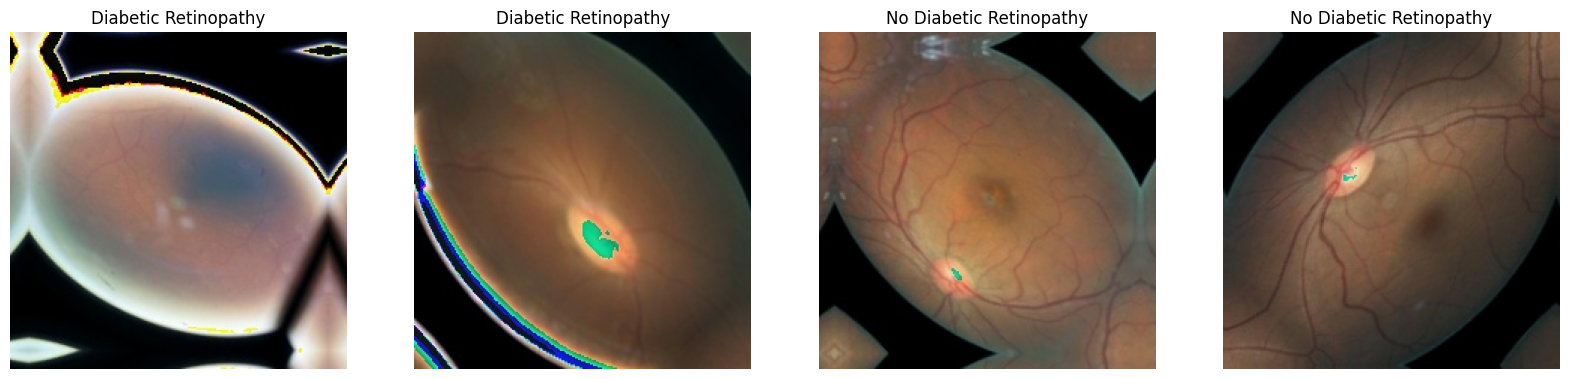

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Paths of predicted images
images = [
    ("/content/drive/MyDrive/MAIN_PROJECT/Test/1/39134_right_aug4.jpg", "Diabetic Retinopathy"),
    ("/content/drive/MyDrive/MAIN_PROJECT/Test/1/40323_left_aug4.jpg", "Diabetic Retinopathy"),
    ("/content/drive/MyDrive/MAIN_PROJECT/Test/0/1212_left_aug1.jpg", "No Diabetic Retinopathy"),
    ("/content/drive/MyDrive/MAIN_PROJECT/Test/0/12216_right_aug3.jpg", "No Diabetic Retinopathy")
]

# Display the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (path, label) in enumerate(images):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    axes[idx].imshow(img)
    axes[idx].set_title(label)  # Only display the label
    axes[idx].axis("off")

plt.show()


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=da044d80a4be2d47575b4bd629dd324699783bc44d5ddeb471a2b7f4bea0a54c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Explaining /content/drive/MyDrive/MAIN_PROJECT/Test/1/39134_right_aug4.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

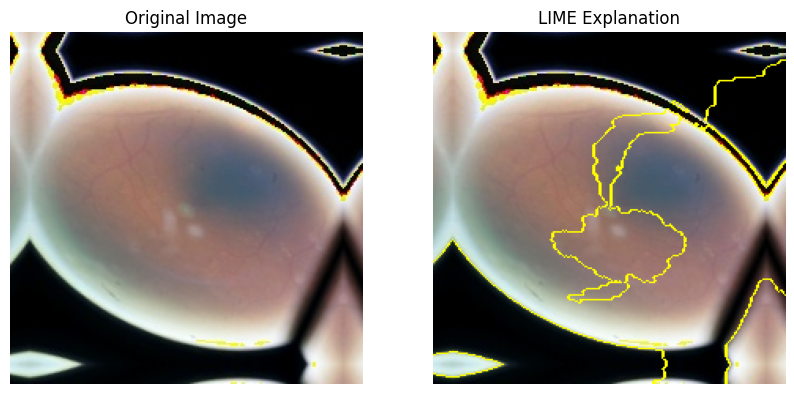

Explaining /content/drive/MyDrive/MAIN_PROJECT/Test/1/40323_left_aug4.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

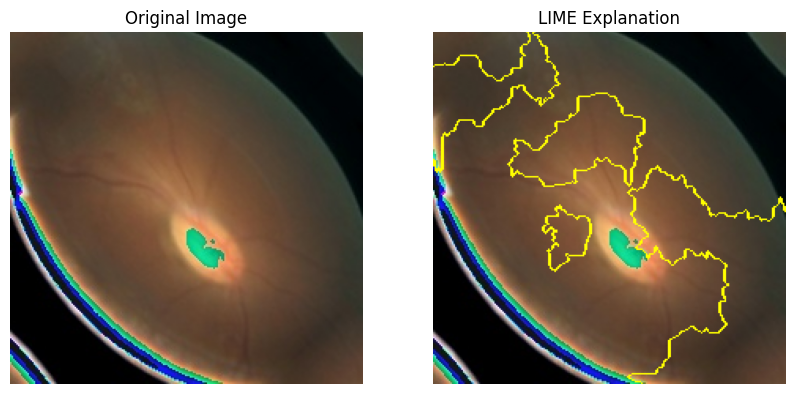

Explaining /content/drive/MyDrive/MAIN_PROJECT/Test/0/1212_left_aug1.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

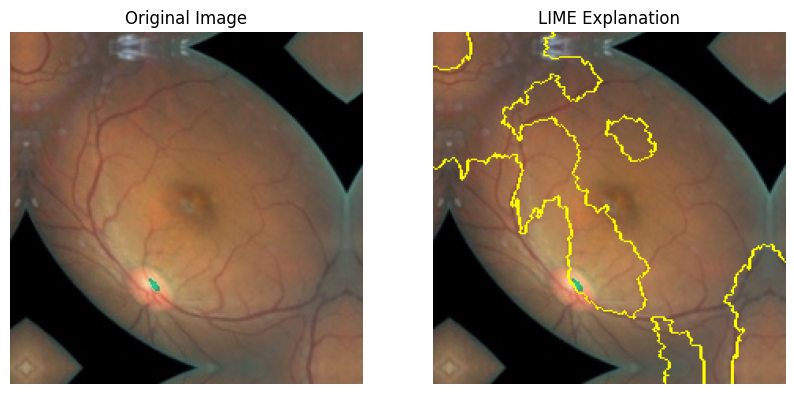

Explaining /content/drive/MyDrive/MAIN_PROJECT/Test/0/12216_right_aug3.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

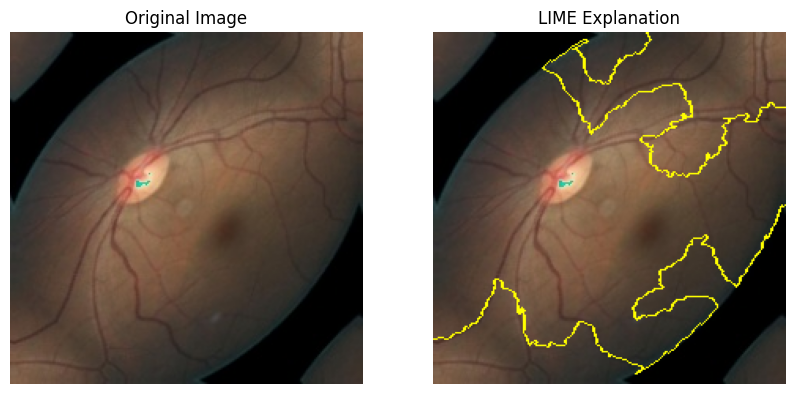

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load the trained model
model_path = "/content/drive/MyDrive/MAIN_PROJECT/best_model.keras"
model = tf.keras.models.load_model(model_path)

# Function to preprocess an image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img / 255.0  # Normalize
    return np.expand_dims(img, axis=0)

# Function to explain predictions using LIME
def explain_image(image_path, model):
    img = preprocess_image(image_path)[0]  # Remove batch dimension for LIME
    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        return model.predict(np.array(images))

    explanation = explainer.explain_instance(img, predict_fn, top_labels=2, hide_color=0, num_samples=1000)

    # Get explanation for the predicted class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

    # Display original and explained image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(mark_boundaries(temp, mask))
    ax[1].set_title("LIME Explanation")
    ax[1].axis("off")

    plt.show()

# List of correctly predicted images
correct_images = [
    "/content/drive/MyDrive/MAIN_PROJECT/Test/1/39134_right_aug4.jpg",  # DR
    "/content/drive/MyDrive/MAIN_PROJECT/Test/1/40323_left_aug4.jpg",   # DR
    "/content/drive/MyDrive/MAIN_PROJECT/Test/0/1212_left_aug1.jpg",    # No DR
    "/content/drive/MyDrive/MAIN_PROJECT/Test/0/12216_right_aug3.jpg"   # No DR
]

# Apply LIME explanation on selected images
for img_path in correct_images:
    print(f"Explaining {img_path}")
    explain_image(img_path, model)
